<h1><center>Stock Order Executions using Hierarchical Reinforcement Learning</center></h1>

This notebook will walk you through the portion of Hierarchical Reinforcement Learning using LSTMs. We will go over various important concepts such as Cooperation between agents and Hierarchical division of tasks. We will make use of a custom-designed stock trading environment wherein our agent will first predict the price at the next time-step and then make decisions of buying and selling shares. The agent constitutes of two sub-agents which work in cooperation and share the joint reward function $R$, i.e- $R_{1} = R_{2} = R$. The trading process is modeled as a Markov game presented as follows-  

<center>$V_{\pi^{1},\pi^{2}}(s_{t}) = \mathbb{E}[\sum_{t \geq 0} \gamma^{t}R(s_{t},a_{t},s_{t+1})|a_{t}^{i}~\pi^{i}(.,s_{t})]$</center>  

Here, $\pi^{i}$ indicates the policy corresponding to agent $i$ where $i \in [1,2]$, $s_{t}$ is the state at time-step $t$, $a_{t}$ is the action executed at time-step $t$, $V_{\pi^{1},\pi^{2}}^{i}(s_{t})$ is the expected value, or value function, of long-term reward $R$ with $\gamma$ being the discount factor. The Nash Equilibrium for the two-player cooperative Markov Game can be presented as-  

<center>$\pi^{*} = (\pi^{1,*},\pi^{2,*})$</center>  

where $\pi^{i,*}$ is the optimal policy corresponding to agent $i$ such that $i \in [1,2]$ and $\pi^{*}$ is the joint set of optimal policies of all agents.

## 1. Import Dependencies 
Let's import the relevant libraries which we would be using for our experiments. Mainly, we make use of PyTorch and Gym(by OpenAI) for the Q-Learning implementation. 

In [2]:
from google.colab import drive
user_name = '/content/drive'
drive.mount(user_name, force_remount=True)

#General Imports
import gym
import json
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

#Torch and Baseline Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from stable_baselines.common.vec_env import DummyVecEnv

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Code/Checkpoint-Trade'
load_checkpoint = '/content/drive/My Drive/Colab Notebooks/Code/Checkpoints/'
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Code/')
from Stock_Trade_Env import StockTradingEnv

#Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## 2. Replay Buffer
Almost all Reinforcement Learning methods make use of a Replay Buffer which saves past experiences from a particular episode. Each $(state,action,reward,next_state)$ tuple is stored in the buffer so that the RL algorithm can be trained later when the episode is over.

In [0]:
class ReplayBuffer:
  def __init__(self,capacity): 
    self.capacity = capacity
    self.buffer = []
    self.position = 0

  def push(self, state,state_order,act,dec,reward,next_state,done):
      state      = state.detach().cpu().numpy()
      next_state = next_state
      state_order = state_order.detach().cpu().numpy()
      act = act.detach().cpu().numpy()
      self.buffer.append((state,state_order,act,dec,reward,next_state,done))
  
  def sample(self, batch_size):
      state,state_order,act,dec,reward,next_state,done = zip(*random.sample(self.buffer, batch_size))
      return np.concatenate(state), np.concatenate(state_order), np.concatenate(act), dec, reward, np.concatenate(next_state), done
  
  def __len__(self):
      return len(self.buffer)

## 3. The Trading Environment
### 3.1 Create the Custom Environment
It's time to create our reinforcement learning environment wherein our agent will interact with states, i.e- stock price values and receive rewards for making decisions. The value of reward will depend on the amount gained on the net value, i.- the price at which the agent bought/sold a share of the stock. Following are the functions required to create the environment-  
$\rightarrow$ An environment can be initialized by using the $class$ methods. This class would broadly consist of 3 functions and these are $reset$, $step$ and $render$. Let's have a look at them one-by-one.  
$\rightarrow$ The $reset$ function, as the name suggests, will reset the environment to a random state. In terms of our learning setup, it will yield the next price value from the sequence set to the agent.  
$\rightarrow$ The $step$ function will allow the model to take a step in the environment. The function would take the action from the agent as the input and output the $next-state$ and $reward$. Our environment will output another value called $done$ which is a boolean indicating the comletion of an episode.  
$\rightarrow$ The $render$ function will output the progress of the agent in the environment on the screen. This is typically useful for Atari 2600 domain wherein the environment renders $next-states$ as output screens from the game.  

In [ ]:
import random
import json
import gym
from gym import spaces
import pandas as pd
import numpy as np

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 10000


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.reward_range = (0, MAX_ACCOUNT_BALANCE)

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6, 6), dtype=np.float16)
        
    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step: self.current_step +
                        5, 'Open'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'High'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Low'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Close'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Volume'].values / MAX_NUM_SHARES,
        ])

        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[
            self.balance / MAX_ACCOUNT_BALANCE,
            self.max_net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.cost_basis / MAX_SHARE_PRICE,
            self.total_shares_sold / MAX_NUM_SHARES,
            self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),
        ]], axis=0)

        return obs

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(
            self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])

        action_type = action[0]
        amount = action[1]
        
        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (
                prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    
    def step(self,action):
        # Execute one time step within the environment
        self._take_action(action)

        self.current_step += 1

        if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
            self.current_step = 0

        delay_modifier = (self.current_step / MAX_STEPS)

        reward = self.balance * delay_modifier
        done = self.net_worth <= 0

        obs = self._next_observation()
        
        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(
            0, len(self.df.loc[:, 'Open'].values) - 6)

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
#         print(f'Step: {self.current_step}')
#         print(f'Balance: {self.balance}')
#         print(
#             f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
#         print(
#             f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
#         print(
#             f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
#         print(f'Profit: {profit}')
        return self.balance, self.shares_held, self.total_shares_sold, self.cost_basis, self.total_sales_value, self.net_worth, profit
        


### 3.2 Pull Data
Our environment will simulate a real market-like behavior by taking in values from a particular stock. We will download our stock data using the $yfinance$ library and feed it as a dataframe to the environment. 

In [0]:
ticker = 'NVDA'
# data = yf.download(ticker, '2020-01-08', '2020-03-05', interval='2m')
# data = data.to_csv('./data.csv')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Code/data/'+ticker+'.csv')
print(data.shape)
env = DummyVecEnv([lambda: StockTradingEnv(data)])

(5427, 7)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 4. Model Instantiation 
Now we move on to the main step wherein we construct our agent and initialize all its parameters. We are using an LSTM model for along with Linear FC layers. We use a single layer in our model along with some dropout and a Dense layer.
Recall the gated structure of each cell in the LSTM and the equations corresponding to its pass-  
Forget Gate  
<center>$f_{t} = \sigma(W_{f}.[h_{t-1},x_{t}] + b_{f})$</center>  
Input Gate-  
<center>$\bar{C_{t}} = tanh(W_{c}.[h_{t-1},x_{t}] + b_{c})$</center>  
<center>$i_{t} = \sigma(W_{i}.[h_{t-1},x_{t}] + b_{i})$</center>  
Update Cell State-  
<center>$ C_{t} = f_{t}*C_{t-1} + i_{t}*\bar{C_{t}}$</center>  
Output-  
<center>$ o_{t} = \sigma(W_{o}[h_{t-1},x_{t}] + b_{0})$</center>  


### 4.1 Actor Network
We will now make the first part of our agent, the manager network. The manager network will be responsible for predicting the price at the next-time step, i.e- the future value of the stock. Input to the manager network will be the state from the environment and output, the Q-value, will be treated as a scaled version of the price at the next time-step.In terms of the architecture, we keep our models simple by making use of LSTM cells and Linear layers with Dropout. 

In [0]:
class ManagerNetwork(nn.Module): 
    def __init__(self, num_inputs, hidden_size):
        super(ManagerNetwork, self).__init__()   
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=num_inputs,hidden_size=self.hidden_size,num_layers=1,batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(2*self.hidden_size,6)
        
    def forward(self, state): 
        h0 = torch.zeros(2, state.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(2, state.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(state, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def act(self, state, epsilon):
        pred = self.forward(state)
        return pred

### 4.2 Order Network
The order network will output the action for the bid, buy or sell. Input to the order network will be the state concatenated with the predicted price by the manager network.

In [0]:
class OrderNetwork(nn.Module): 
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(OrderNetwork, self).__init__()  
        self.hidden_size = hidden_size
        self.num_actions = num_actions
        self.lstm = nn.LSTM(input_size=num_inputs,hidden_size=self.hidden_size,num_layers=1,batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(2*self.hidden_size,self.num_actions)
        
    def forward(self, state): 
        h0 = torch.zeros(2, state.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(2, state.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(state, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = F.softmax(out)
        prob = max(out[0,:])
        action = torch.argmax(out,dim=1)
        return out, prob, action

    def act(self, state, epsilon):
          if random.random() > epsilon:
            _, prob, action = self.forward(state)
          else:
              prob = random.uniform(0,1)
              action = random.randint(0,1)
          return prob, action

## 5. Update Rule
Now we will make our update rule for the multi-agent algorithm. We will make use of Q-Learning which updates our parameters based on the best/greedy Q-action value $\underset{a}{max}Q(s^{'},a)$. Here, $s^{'}$ is the next state and $a$ is the action selected. The algorithm can be mathematically expressed as followed-,  
$Initialize\; Q(s,a), \forall s \in S, \forall a \in A, \; Q(term\_state,.) = 0$  
$Repeat(for\; each\; episode):$  
$\qquad a,s \leftarrow \pi(s,a)$  
$\qquad execute\quad a$  
$\qquad observe\quad r,s^{'}$  
$\qquad Q(s,a)\leftarrow Q(s,a) + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a) - Q(s,a)]$  
$\qquad s\leftarrow s^{'}$  
$until\; s\; is\; terminal$  

Notice that the update $Q(s,a)\leftarrow Q(s,a) + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a) - Q(s,a)]$ is greedy w.r.t the policy $\pi (s,a)$. Thus, Q-Learning will sample the best action value $\underset{a}{argmax}Q(s,a)$ irrespective of exploration. Hence it is good practice to make the agent explore the environment sufficiently for long-horizon rewards.  
Weight updates for our agents take similar form as the Q-updates-  

<center>$w\leftarrow w + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a,w) - Q(s,a,w)]\nabla Q(s,a,w)$</center>  

For our experiment, we will compute the TD Loss corresponding to each agent as the MSE difference between the Q-value and the expected Q-value ($\underset{a}{max}Q(s^{'},a)$). Mathematically,  

<center>$L = \frac{1}{N}\sum_{i}[Q(s,a) - \underset{a}{max}Q(s^{'},a)]^{2}$</center>  

The total loss will be the weighted sum of the manager and order network losses.

In [0]:
def compute_td_loss(batch_size):

    state,state_order,act,dec,reward,next_state,done = replay_buffer.sample(batch_size)
    
    action_act = torch.LongTensor(act).to(device)
    action_order = torch.LongTensor(dec).unsqueeze(1).to(device)
    state      = torch.FloatTensor(np.float32(state)).to(device)
    state_order      = torch.FloatTensor(state_order).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)
    
    criterion = nn.SmoothL1Loss(reduction='none')

    # Manager(Actor) Network
    q_values_act      = policy_net_act(state)
    next_q_values_act = policy_net_act(next_state)
    q_value_act          = q_values_act.gather(1, action_act).squeeze(1)
    next_q_value_act     = next_q_values_act#.max(1)[0]
    norm = max(rewards) if rewards!=[] else 1
    norm = torch.FloatTensor(norm).to(device)
    expected_q_value_act = (reward/norm) + gamma * next_q_value_act * (1 - done)
    act_loss = criterion(q_value_act,Variable(expected_q_value_act.data))
    act_loss = torch.sum(torch.mean(act_loss,0))
#     act_loss = (q_value_act - Variable(expected_q_value_act.data)).pow(2).mean() 
#     optimizer_act.zero_grad()
#     act_loss.backward()
#     optimizer_act.step()

    # Order Network
    q_values_order,_, _      = policy_net_order(state_order)
    q_value_act = torch.unsqueeze(q_value_act,0).permute(1,0,2)
    next_state_order = torch.cat([next_state,q_value_act],1).to(device)
    next_q_values_order,_, _ = policy_net_order(next_state_order)
    next_q_value_order     = next_q_values_order.unsqueeze(1).max(1)[0].type(torch.FloatTensor).to(device)
    expected_q_value_order = (reward/norm) + gamma * next_q_value_order * (1 - done) 
    order_loss = criterion(q_values_order,Variable(expected_q_value_order.data))
    order_loss = torch.sum(torch.mean(order_loss,0))
#     order_loss = (torch.FloatTensor(q_values_order) - torch.FloatTensor(expected_q_value_order)).pow(2).mean()
    total_loss = 0.5*act_loss + 0.5*order_loss
    optimizer_order.zero_grad()
    total_loss.backward()
    clip_grad_value_(policy_net_act.parameters(), 0.2)
    clip_grad_value_(policy_net_order.parameters(), 0.2)
    optimizer_order.step()
 
#     total_loss = 0.3*act_loss + 0.7*order_loss
    
    return order_loss.detach().cpu().numpy(), act_loss.detach().cpu().numpy(), total_loss.detach().cpu().numpy()

## 6. Test Performance
We write our main training loop in typical PyTorch style and allow the model to train for a fixed number of frames. We add a new paramter here called $epsilon$ which controls the amount of exploration of the agent. Typically a high starting value of $epsilon$ along with decay would help the agent gain sufficient knowledge of the environment.

In [0]:
replay_initial = 100
replay_buffer = ReplayBuffer(100000)

obs = env.reset()
state_dim_act = obs.shape[2]
state_dim_order = obs.shape[2]
action_dim = 2
print('Launching Environment...')
batch_size = 32
hidden_dim = 64

policy_net_act = ManagerNetwork(state_dim_act,hidden_dim).to(device)
policy_net_order = OrderNetwork(state_dim_order,action_dim,hidden_dim).to(device)
policy_lr = 1e-3
optimizer_order = optim.Adam(policy_net_order.parameters(),lr=policy_lr)

ord_l = None
act_l = None
TD_Loss = None
load_model = False 
if load_model==True:
  #Load Actor Policy Net
    policy_checkpoint = torch.load(checkpoint_name+'/policy_net_act.pth.tar',map_location='cpu') 
    policy_net_act.load_state_dict(policy_checkpoint['model_state_dict'])
    optimizer_act.load_state_dict(policy_checkpoint['optimizer_state_dict'])
    TD_Loss = policy_checkpoint['loss']
  #Load Order Policy Net
    policy_checkpoint = torch.load(checkpoint_name+'/policy_net_order.pth.tar',map_location='cpu') 
    policy_net_order.load_state_dict(policy_checkpoint['model_state_dict'])
    optimizer_order.load_state_dict(policy_checkpoint['optimizer_state_dict'])
    TD_Loss = policy_checkpoint['loss']

num_frames  = 100000 #Steps
rewards = [];loss_order = [];loss_actor = [];loss = [];profit = [];forecast = []
gamma = 0.99

epsilon_start = 0.90
epsilon_final = 0.01
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

print('Training Started...')
print('-'*100)
state = obs

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    state = torch.FloatTensor(state).to(device)
    act = policy_net_act.act(state, epsilon)
    forecast.append(act)
    state_order = torch.cat([state,torch.unsqueeze(act,0)],1).to(device)
    order,dec = policy_net_order.act(state_order, epsilon)
    action = np.array([dec,order])
    action = np.expand_dims(action,axis=1)
    action = action.T
    next_state,reward,done,_ = env.step(action)
    bal, s_held, s_sold, cost, sales, net, prof = env.render()
        
    replay_buffer.push(state,state_order,act,dec,reward,next_state,done)
    
    frame_idx += 1
    state = next_state
    
    if len(replay_buffer) > replay_initial:
        ord_l, act_l, TD_Loss = compute_td_loss(batch_size)
    
    if (frame_idx%1000)==0:
        print('Step-', str(frame_idx), '/', str(num_frames), '| Profit-', prof,'| Model Loss-', ord_l)
        torch.save({'model_state_dict': policy_net_act.state_dict(), 'optimizer_state_dict': optimizer_order.state_dict(), 'loss': TD_Loss},checkpoint_name+'/policy_net_act.pth.tar') #save PolicyNet
        torch.save({'model_state_dict': policy_net_order.state_dict(), 'optimizer_state_dict': optimizer_order.state_dict(), 'loss': TD_Loss},checkpoint_name+'/policy_net_order.pth.tar') #save PolicyNet
        
    rewards.append(reward),loss.append(TD_Loss),loss_actor.append(act_l),loss_order.append(ord_l),profit.append(prof)
    
    if done:
        state = env.reset()
        
data_save = {}
data_save['prediction'] = forecast
data_save['reward'] = profit;data_save['loss'] = loss;data_save['act_loss'] = loss_actor;data_save['order_loss'] = loss_order
with open(checkpoint_name+'/data_save.pkl', 'wb') as f: #data+same as frame folder
    pickle.dump(data_save, f)

print('-'*100)
print('Training Completed')


Launching Environment...
Training Started...
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Step- 1000 / 100000 | Profit- -666.7077617756204 | Model Loss- 0.15703018
Step- 2000 / 100000 | Profit- -241.53187379114388 | Model Loss- 0.14510393
Step- 3000 / 100000 | Profit- 422.7402731870152 | Model Loss- 0.114876464
Step- 4000 / 100000 | Profit- 373.58739319170854 | Model Loss- 0.12930197
Step- 5000 / 100000 | Profit- 326.94024644784076 | Model Loss- 0.106336385
Step- 6000 / 100000 | Profit- -224.3854229051558 | Model Loss- 0.14435452
Step- 7000 / 100000 | Profit- -362.2951979960417 | Model Loss- 0.19852427
Step- 8000 / 100000 | Profit- -203.76319392513324 | Model Loss- 0.1953794
Step- 9000 / 100000 | Profit- -367.39822416169227 | Model Loss- 0.14555328
Step- 10000 / 100000 | Profit- -716.9492106799626 | Model Loss- 0.14169526
Step- 11000 / 100000 | Profit- -1070.5350919235789 | Model Loss- 0.1731453
Step- 12000 / 100000 | Profit- -1057.9795348011594 | Model Loss- 0.12280796
Step- 13000 / 100000 | Profit- -645.0065656783081 | Model Loss- 0.12728891
Step- 14000 / 100000 | Profit-

## 8. Plot Results
Results are saved as $.pkl$ files and loaded to compare and observe the model's performance under different stocks. 

In [ ]:

plot_lst = ['AAPL','AMZN','GOOGL','MSFT','NFLX','NVDA']
attr = ['loss','act_loss','order_loss','reward','prediction']
plot_1 = {}

for j in plot_lst:
  dat = pickle.load(open(load_checkpoint+j+"/data_save.pkl", "rb"))
  print(j)
  for k in attr:
      plot_1[j+k] = dat[k]
      plot_1[j+k] = dat[k]
      plot_1[j+k] = dat[k]
      plot_1[j+k] = dat[k]
      plot_1[j+k] = dat[k]
      plot_1[j+k] = dat[k]


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


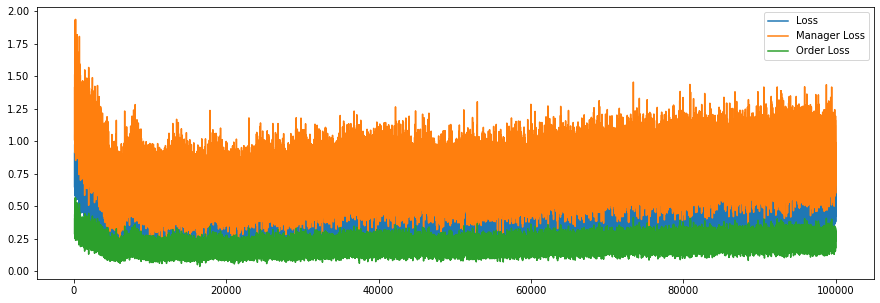

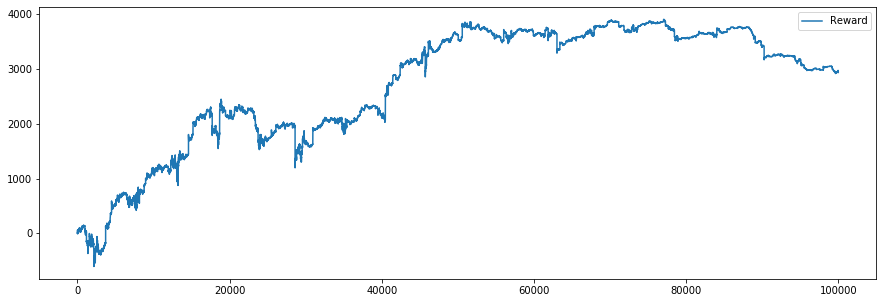

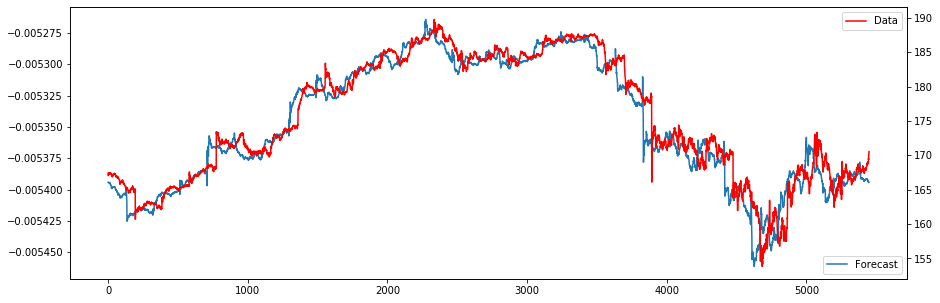

In [25]:
#Plot reward and loss
plt.figure(figsize=(15,5))
plt.plot(plot['MSFTloss'])
plt.plot(plot['MSFTact_loss'])
plt.plot(plot['MSFTorder_loss'])
plt.legend(['Loss','Manager Loss','Order Loss'])

plt.figure(figsize=(15,5))
plt.plot(plot['MSFTreward'])
plt.legend(['Reward'])

predictions = []
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Code/data/'+'MSFT'+'.csv')
for j in plot['MSFTprediction']:
  predictions.append(j.data.cpu().numpy()[0,1])
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.plot(predictions[3000:8450])
plt.legend(['Forecast'],loc='lower right')
ax2 = ax1.twinx()
ax2.plot(data['Close'],'r-')
plt.legend(['Data'],loc='upper right')
